### Import necessary libraries

In [293]:
import SimpleITK as sitk
from ndreg import *
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
from requests import HTTPError
import time
import datetime
import matplotlib
import skimage
from skimage import filters, morphology
import sklearn
import numpy as np

In [294]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [295]:
def create_channel_resource(rmt, chan_name, coll_name, exp_name, type='image', base_resolution=0, sources=[], datatype='uint16', new_channel=True):
    channel_resource = ChannelResource(chan_name, coll_name, exp_name, type=type, base_resolution=base_resolution, sources=sources, datatype=datatype)
    if new_channel: 
        new_rsc = rmt.create_project(channel_resource)
        return new_rsc

    return channel_resource

def upload_to_boss(rmt, data, channel_resource, resolution=0):
    Z_LOC = 0
    size = data.shape
    for i in range(0, data.shape[Z_LOC], 16):
        last_z = i+16
        if last_z > data.shape[Z_LOC]:
            last_z = data.shape[Z_LOC]
        print(resolution, [0, size[2]], [0, size[1]], [i, last_z])
        rmt.create_cutout(channel_resource, resolution, [0, size[2]], [0, size[1]], [i, last_z], np.asarray(data[i:last_z,:,:], order='C'))

def download_ara(rmt, resolution, type='average'):
    if resolution not in [10, 25, 50, 100]:
        print('Please provide a resolution that is among the following: 10, 25, 50, 100')
        return
    REFERENCE_COLLECTION = 'ara_2016'
    REFERENCE_EXPERIMENT = 'sagittal_{}um'.format(resolution)
    REFERENCE_COORDINATE_FRAME = 'ara_2016_{}um'.format(resolution) 
    REFERENCE_CHANNEL = '{}_{}um'.format(type, resolution)

    refImg = download_image(rmt, REFERENCE_COLLECTION, REFERENCE_EXPERIMENT, REFERENCE_CHANNEL, ara_res=resolution)

    return refImg

def download_image(rmt, collection, experiment, channel, res=0, isotropic=True, ara_res=None):
    (exp_resource, coord_resource, channel_resource) = setup_channel_boss(rmt, collection, experiment, channel)
    img = imgDownload_boss(rmt, channel_resource, coord_resource, resolution=res, isotropic=isotropic)
    return img

def downsample_images(spacing, atlas, sampleImg, refThreshold, sampleThreshold):
    downsample_spacing = [spacing,spacing,spacing]

    print("downsampling images to {}...".format(spacing))

    refImg_ds = sitk.Clamp(imgResample(atlas, downsample_spacing), upperBound=refThreshold)

    sampleImg_ds = sitk.Clamp(imgResample(sampleImg, downsample_spacing), upperBound=sampleThreshold)

    print("downsampling done!")

    return (refImg_ds, sampleImg_ds)

In [296]:
def imgBC(img, mask=None, scale=1.0, numBins=64):
    """
    Bias corrects an image using the N4 algorithm
    """
    spacing = np.array(img.GetSpacing())/scale
    img_ds = imgResample(img, spacing=spacing)

    # Calculate bias
    if mask is None:
        mask = sitk.Image(img_ds.GetSize(), sitk.sitkUInt8)+1
        mask.CopyInformation(img_ds)
    else:
        mask = imgResample(mask, spacing=spacing)

    img_ds_bc = sitk.N4BiasFieldCorrection(sitk.Cast(img_ds, sitk.sitkFloat32), mask, numberOfHistogramBins=numBins)
    bias_ds = img_ds_bc - sitk.Cast(img_ds,img_ds_bc.GetPixelID())
    
    # Upsample bias
    bias = imgResample(bias_ds, spacing=img.GetSpacing(), size=img.GetSize())

    # Apply bias to original image and threshold to eliminate negitive values
    upper = np.iinfo(sitkToNpDataTypes[img.GetPixelID()]).max
    img_bc = sitk.Threshold(img + sitk.Cast(bias, img.GetPixelID()),
                            lower=0, upper=upper)
    return img_bc

In [297]:
def imgMetamorphosis(inImg, refImg, alpha=0.02, beta=0.05, scale=1.0, iterations=1000, epsilon=None, sigma=1e-4, useNearest=False,
                     useBias=False, useMI=False, verbose=False, debug=False, inMask=None, refMask=None, outDirPath=""):
    """
    Performs Metamorphic LDDMM between input and reference images
    """
    useTempDir = False
    if outDirPath == "":
        useTempDir = True
        outDirPath = tempfile.mkdtemp() + "/"
    else:
        outDirPath = dirMake(outDirPath)

    inPath = outDirPath + "in.img"
    imgWrite(inImg, inPath)
    refPath = outDirPath + "ref.img"
    imgWrite(refImg, refPath)
    outPath = outDirPath + "out.img"

    fieldPath = outDirPath + "field.vtk"
    invFieldPath = outDirPath + "invField.vtk"

    binPath = ndregDirPath + "metamorphosis "
    steps = 5
    command = binPath + " --in {0} --ref {1} --out {2} --alpha {3} --beta {4} --field {5} --invfield {6} --iterations {7} --scale {8} --steps {9} --verbose ".format(
        inPath, refPath, outPath, alpha, beta, fieldPath, invFieldPath, iterations, scale, steps)
    if(not useBias):
        command += " --mu 0"
    if(useMI):
        # command += " --cost 1 --sigma 1e-5 --epsilon 1e-3"
        command += " --cost 1 --sigma {}".format(sigma)
#         command += " --epsilon {0}".format(epsilon)
        if not(epsilon is None):
            command += " --epsilon {0}".format(epsilon)
        else:
            command += " --epsilon 1e-3"
    else:
        command += " --sigma {}".format(sigma)
#         command += " --epsilon {0}".format(epsilon)
        if not(epsilon is None):
            command += " --epsilon {0}".format(epsilon)
        else:
            command += " --epsilon 1e-3"
    if(inMask):
        inMaskPath = outDirPath + "inMask.img"
        imgWrite(inMask, inMaskPath)
        command += " --inmask " + inMaskPath

    if(refMask):
        refMaskPath = outDirPath + "refMask.img"
        imgWrite(refMask, refMaskPath)
        command += " --refmask " + refMaskPath

    if debug:
        command = "/usr/bin/time -v " + command
        print(command)

    # os.system(command)
    (returnValue, logText) = run(command, verbose=verbose)

    logPath = outDirPath + "log.txt"
    txtWrite(logText, logPath)

    field = imgRead(fieldPath)
    invField = imgRead(invFieldPath)

    if useTempDir:
        shutil.rmtree(outDirPath)
    return (field, invField)


def imgMetamorphosisComposite(inImg, refImg, alphaList=0.02, betaList=0.05, scaleList=1.0, iterations=1000, epsilonList=None, sigma=1e-4,
                              useNearest=False, useBias=False, useMI=False, inMask=None, refMask=None, verbose=True, debug=False, outDirPath=""):
    """
    Performs Metamorphic LDDMM between input and reference images
    """
    useTempDir = False
    if outDirPath == "":
        useTempDir = True
        outDirPath = tempfile.mkdtemp() + "/"
    else:
        outDirPath = dirMake(outDirPath)

    if isNumber(alphaList):
        alphaList = [float(alphaList)]
    if isNumber(betaList):
        betaList = [float(betaList)]
    if isNumber(scaleList):
        scaleList = [float(scaleList)]

    numSteps = max(len(alphaList), len(betaList), len(scaleList))

    if isNumber(epsilonList):
        epsilonList = [float(epsilonList)] * numSteps
    elif epsilonList is None:
        epsilonList = [None] * numSteps

    if len(alphaList) != numSteps:
        if len(alphaList) != 1:
            raise Exception(
                "Legth of alphaList must be 1 or same length as betaList or scaleList")
        else:
            alphaList *= numSteps

    if len(betaList) != numSteps:
        if len(betaList) != 1:
            raise Exception(
                "Legth of betaList must be 1 or same length as alphaList or scaleList")
        else:
            betaList *= numSteps

    if len(scaleList) != numSteps:
        if len(scaleList) != 1:
            raise Exception(
                "Legth of scaleList must be 1 or same length as alphaList or betaList")
        else:
            scaleList *= numSteps

    origInImg = inImg
    origInMask = inMask
    for step in range(numSteps):
        alpha = alphaList[step]
        beta = betaList[step]
        scale = scaleList[step]
        epsilon = epsilonList[step]
        stepDirPath = outDirPath + "step" + str(step) + "/"
        if(verbose):
            print("\nStep {0}: alpha={1}, beta={2}, scale={3}".format(
                step, alpha, beta, scale))

        (field, invField) = imgMetamorphosis(inImg, refImg,
                                             alpha,
                                             beta,
                                             scale,
                                             iterations,
                                             epsilon,
                                             sigma,
                                             useNearest,
                                             useBias,
                                             useMI,
                                             verbose,
                                             debug,
                                             inMask=inMask,
                                             refMask=refMask,
                                             outDirPath=stepDirPath)

        if step == 0:
            compositeField = field
            compositeInvField = invField
        else:
            compositeField = fieldApplyField(field, compositeField)
            compositeInvField = fieldApplyField(compositeInvField, invField, size=field.GetSize(
            ), spacing=field.GetSpacing())  # force invField to be same size as field

            if outDirPath != "":
                fieldPath = stepDirPath + "field.vtk"
                invFieldPath = stepDirPath + "invField.vtk"
                imgWrite(compositeInvField, invFieldPath)
                imgWrite(compositeField, fieldPath)

        inImg = imgApplyField(origInImg, compositeField, size=refImg.GetSize())
        if(inMask):
            inMask = imgApplyField(origInMask,
                                   compositeField, size=refImg.GetSize(), useNearest=True)
        # vikram added this
        imgShow(inImg, vmax=imgPercentile(inImg, 0.99))

    # Write final results
    if outDirPath != "":
        imgWrite(compositeField, outDirPath + "field.vtk")
        imgWrite(compositeInvField, outDirPath + "invField.vtk")
        imgWrite(inImg, outDirPath + "out.img")
        imgWrite(imgChecker(inImg, refImg), outDirPath + "checker.img")

    if useTempDir:
        shutil.rmtree(outDirPath)
    return (compositeField, compositeInvField)

# Step 1: Download atlas and input images

In [298]:
rmt = BossRemote(cfg_file_or_dict='/run/data/.intern/intern.cfg')

In [299]:
# constants
araRes = 50 # um
sampleCollection = 'ailey-dev'
sampleExperiment = 'Thy1eYFP_Control_9_upload20170919'
sampleChannel = 'Ch1'
sampleRes = 3
sampleIso = True

### Downloading ARA Average image

In [300]:
refImg = download_ara(rmt, araRes)
# refImg = imgRead("ara3_average_res2.img")

In [301]:
print(refImg.GetSpacing())
print(refImg.GetSize())

(0.05, 0.05, 0.05)
(264, 160, 228)


In [302]:
refThreshold = imgPercentile(refImg, 0.999)
print(refThreshold)

331.858823529


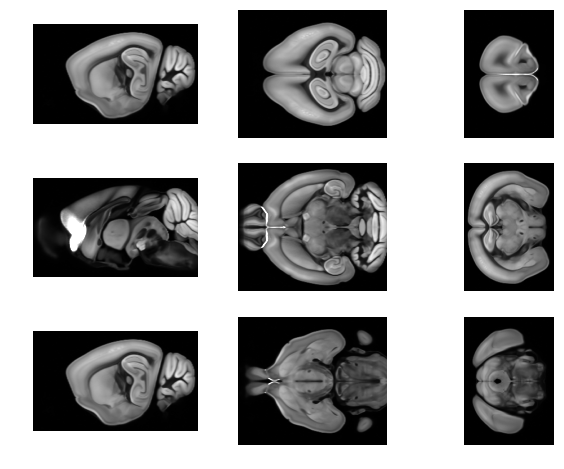

In [303]:
imgShow(refImg, vmax=refThreshold)

### Downloading input image

In [304]:
inImg_orig = download_image(rmt, sampleCollection, sampleExperiment, sampleChannel, res=sampleRes, isotropic=sampleIso)
# inImg_orig = imgRead('ailey-dev_thy1eyfp_control_9_upload20170919_ch1_res3.img')

In [305]:
print(inImg_orig.GetSize())
print(inImg_orig.GetSpacing())

(270, 320, 178)
(0.041280000000000004, 0.041280000000000004, 0.041280000000000004)


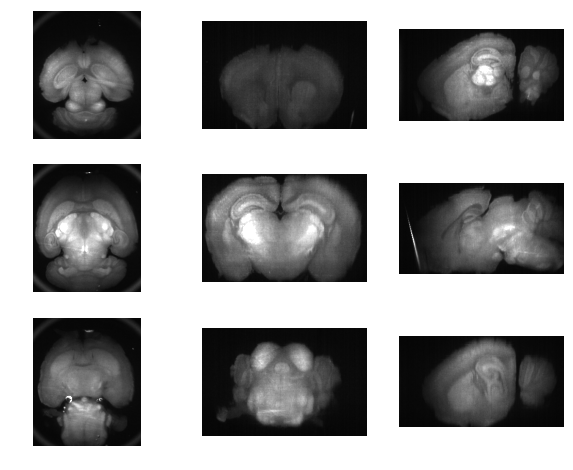

In [306]:
inThreshold = imgPercentile(inImg_orig, 0.999)
imgShow(inImg_orig, vmax=inThreshold)

In [307]:
print(inImg_orig.GetSize())
print(inImg_orig.GetSpacing())

(270, 320, 178)
(0.041280000000000004, 0.041280000000000004, 0.041280000000000004)


# Step 3: Perform Registration

In [308]:
fixedImage = inImg_orig
movingImage = refImg
# fixedImage = inImg_ds
# movingImage = refImg_ds

In [309]:
fixedImage.GetSpacing()

(0.041280000000000004, 0.041280000000000004, 0.041280000000000004)

In [310]:
movingImage.GetSpacing()

(0.05, 0.05, 0.05)

In [311]:
print(fixedImage.GetSize())
print(movingImage.GetSize())

(270, 320, 178)
(264, 160, 228)


In [312]:
# set parameters
# rigidParameterMap = sitk.GetDefaultParameterMap('rigid')
affineParameterMap = sitk.GetDefaultParameterMap('affine')
# rigidParameterMap['Metric'] = ['AdvancedMeanSquares']
affineParameterMap['Metric'] = ['AdvancedMeanSquares']
affineParameterMap['MaximumNumberOfIterations'] = ['2000.00']
# rigidParameterMap['MaximumNumberOfIterations'] = ['2000.00']
# p['Transform'] = ['TranslationTransform']
# affineParameterMap['AutomaticParameterEstimation'] = ['false']
affineParameterMap['Optimizer'] = ['StandardGradientDescent']
# affineParameterMap['Scales'] = ['2e-10', '2e-10', '2e-10', '2e-10', '2e-10', '2e-10', 
#                                 '2e-10', '2e-10', '2e-10', '5e-3', '5e-3', '5e-3']
affineParameterMap['NumberOfResolutions'] = '8.000000000000000'
# affineParameterMap['MaximumStepLength'] = ['0.000001']

In [313]:
sitk.PrintParameterMap(affineParameterMap)

In [314]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)
elastixImageFilter.SetParameterMap(affineParameterMap)
elastixImageFilter.Execute()

RuntimeError: Exception thrown in SimpleITK ElastixImageFilter_Execute: /SimpleElastix/Code/Elastix/src/sitkElastixImageFilterImpl.cxx:259:
sitk::ERROR: 
itk::ExceptionObject (0x9918070)
Location: "unknown" 
File: /build/Elastix/Core/Main/elxElastixFilter.hxx
Line: 248
Description: itk::ERROR: Self(0x6f01010): Internal elastix error: See elastix log (use LogToConsoleOn() or LogToFileOn()).



In [ ]:
resultImage = elastixImageFilter.GetResultImage()
transformParameterMap = elastixImageFilter.GetTransformParameterMap()[0]

In [ ]:
resultImage.GetSize()

In [ ]:
affine = [float(i) for i in transformParameterMap['TransformParameters']]

In [ ]:
imgShow(resultImage)

In [ ]:
imgShow(imgChecker(inImg_ds, resultImage))

In [ ]:
print(resultImage.GetSize())
print(resultImage.GetSpacing())

# use sigma = (0.1/num voxels) to be consistent with daniel

# LDDMM registration
Now we run LDDMM registration. Here we use *imgMetamorphosisComposite*.  Unlike *imgMetamorphosis* introduced in the [2D registration notebook](2D_Registration.ipynb), this function runs LDDMM in multiple steps using the alpha values specified by in *alphaList*. The *field* and *invField* outputs are the composition of all steps.  Once agan we use a Mutual Information cost because the input brain and reference image have very differnt intensity profiles.

In [ ]:
matching_regularization = (0.1/inImg_ds.GetNumberOfPixels())*100
print(matching_regularization)

In [325]:
(field, invField) = imgMetamorphosisComposite(resultImage, inImg_ds, alphaList=[0.05],
                                              scaleList = [0.0625, 0.125, 0.25], 
                                              epsilonList=1e-4, sigma=matching_regularization,
                                              useMI=False, iterations=200, verbose=True)
# (field, invField) = imgMetamorphosisComposite(resultImage, inImg_ds, alphaList=[0.1, 0.05, 0.02, 0.01],
#                                               scaleList = 0.10, epsilonList=1e-4, sigma=1e-4,
#                                               useMI=False, iterations=400, verbose=True)

In [327]:
affineField = affineToField(affine, field.GetSize(), field.GetSpacing())
fieldComposite = fieldApplyField(field, affineField)

invAffineField = affineToField(affineInverse(affine), invField.GetSize(), invField.GetSpacing())
invFieldComposite = fieldApplyField(invAffineField, invField)

Now we apply the displacement field

In [ ]:
refImg_lddmm = imgApplyField(refImg, fieldComposite, size=inImgReoriented.GetSize(), spacing=inImgReoriented.GetSpacing())
imgShow(refImg_lddmm, vmax=refThreshold)
imgShow(inImgReoriented, vmax=inThreshold)
###imgWrite(imgResample(inImg_lddmm, spacing=[0.04]*3, size=[285,200,330]),"/cis/project/clarity/data/ailey/s3617_to_ara3_res2_refined_refined.img") ###
# inImg_lddmm = imgApplyField(inImgReoriented, fieldComposite, size=refImg.GetSize(), spacing=refImg.GetSpacing())
# imgShow(inImg_lddmm, vmax=inThreshold_clahe)
# imgShow(refImg)
# ###imgWrite(imgResample(inImg_lddmm, spacing=[0.04]*3, size=[285,200,330]),"/cis/project/clarity/data/ailey/s3617_to_ara3_res2_refined_refined.img") ###

### Evaluation LDDMM registration
Now we evaluate the deformable registration using a checkerboard image

In [ ]:
imgShow(imgChecker(refImg_lddmm, inImgReoriented), vmax=inThreshold)
# imgShow(imgChecker(inImg_lddmm, refImg), vmax=inThreshold_clahe)

In [ ]:
# get the registration transformation


# Load fiducials from both sources

# parse the ARA fiducials

In [498]:
import csv

In [917]:
reader = csv.reader(file('../Manual Fiducials/Control9/average_template_10-landmarks.fcsv'))
# skip first line, dont need it
reader.next()
# get the coordinate system
coordinateSystem = reader.next()[0].split()[3]
columns = reader.next()[1:]
atlasLabels = []
atlasLocs = []
# atlas origin is the geometric mean
atlasOrigin = np.array(refImg.GetSize())/2.0
for i in reader:
#     print([float(j) for j in i[1:4]])
#     atlasFids.append([float(j) for j in i[1:4]])
    atlasLabels.append([i[-3]])
    atlasLocs.append([float(j) for j in i[1:4]])

In [918]:
# print(coordinateSystem)
# print(columns)
# print(atlasFids)
atlasLocs = np.array(atlasLocs)
# atlasLandmarks = landmarks(inputLandmarks=atlasFids)
# print(atlasLocs)

In [919]:
# 10x10x10 mm
# mm because of weirdness with slicer. fiducials placed assuming ARA average is isotropic
guessedSpacing = 10 # mm
trueSpacing = 0.01 # mm
atlasOrigin = np.array(refImg.GetSize())/2

In [921]:
# convert to voxel coordinates
# atlasLocs_scaled = np.abs(atlasLocs/guessedSpacing)
atlasLocs_scaled = np.abs(atlasLocs/guessedSpacing) * trueSpacing

In [922]:
# atlasLocs_scaled = atlasLocs_scaled - atlasOrigin
# atlasLocs_scaled = atlasLocs_scaled * trueSpacing

In [923]:
print(atlasLocs_scaled)

[[  8.56413    5.96475    5.7262  ]
 [  4.29346    3.85658    5.72721 ]
 [  7.2663     2.23687    7.26623 ]
 [  7.43444    2.20742    4.13562 ]
 [ 10.8651     1.79089    5.65018 ]
 [  8.45304    3.73652    2.40651 ]
 [  8.42425    3.73787    8.97809 ]
 [  4.22841    3.86584    5.64591 ]
 [  4.18484    5.4456     6.86227 ]
 [  4.19553    5.462      4.49708 ]
 [ 10.6199     1.08915    6.58541 ]
 [ 10.626      1.07933    4.80834 ]
 [  3.05264    4.24608    7.02611 ]
 [  3.158      4.24599    4.4066  ]
 [  3.56343    5.10005    4.6291  ]
 [  3.48365    5.18195    6.72928 ]
 [  4.11293    3.6777     5.3402  ]
 [  4.13666    3.72286    5.97366 ]
 [  3.83426    3.64404    4.07639 ]
 [  3.8656     3.88539    7.17853 ]
 [  5.2026     5.42124    5.68205 ]
 [  6.07691    2.45384    6.43961 ]
 [  6.05863    2.39539    4.94869 ]
 [  6.43852    2.63409    5.3781  ]
 [  6.34674    2.54851    5.98839 ]
 [  7.1762     2.88053    8.66471 ]
 [  7.24354    3.07921    2.69947 ]
 [ 10.5253     2.53634    5.

In [924]:
# construct landmarks
landmarks_scaled = [[atlasLabels[i][0], atlasLocs_scaled[i, 0], atlasLocs_scaled[i, 1], 
                     atlasLocs_scaled[i, 2]] for i in range(len(atlasLabels))]

In [925]:
atlasLandmarks = landmarks(landmarks_scaled)

In [926]:
atlasLandmarks.spacing = refImg.GetSpacing()

In [927]:
atlasLandmarks.GetLandmarks()

[['L-0', 8.5641299999999987, 5.9647500000000004, 5.7262000000000004],
 ['L-1', 4.2934600000000005, 3.8565800000000001, 5.7272100000000004],
 ['L-2', 7.2663000000000002, 2.2368699999999997, 7.2662299999999993],
 ['L-3', 7.4344399999999995, 2.2074200000000004, 4.1356200000000003],
 ['L-4', 10.8651, 1.7908900000000001, 5.6501800000000006],
 ['L-5', 8.4530400000000014, 3.7365200000000001, 2.4065100000000004],
 ['L-6', 8.4242499999999989, 3.73787, 8.9780899999999999],
 ['L-7', 4.2284100000000002, 3.8658399999999999, 5.6459099999999998],
 ['L-8', 4.1848400000000003, 5.4456000000000007, 6.8622700000000014],
 ['L-9', 4.1955299999999998, 5.4620000000000006, 4.4970799999999995],
 ['L-10', 10.619899999999999, 1.0891500000000001, 6.5854099999999995],
 ['L-11', 10.625999999999999, 1.0793299999999999, 4.8083400000000003],
 ['L-12', 3.0526400000000002, 4.2460800000000001, 7.0261100000000001],
 ['L-13', 3.1580000000000004, 4.2459899999999999, 4.4066000000000001],
 ['L-14', 3.5634299999999999, 5.100050

# apply affine transform

In [884]:
print(affine)

[0.99133, 0.00218296, -0.000992778, 0.0326918, 0.967349, 0.000145738, 0.000415128, -8.2923e-05, 0.959543, 0.612865, -0.0594408, 0.0139647]


In [885]:
atlasLandmarks_affine_mm = atlasLandmarks.Affine(affine)

In [929]:
def lmkApplyField(inLmk, field, spacing=[1, 1, 1], dimension=3):
    # Create transform
    transform = sitk.DisplacementFieldTransform(dimension)
    transform.SetInterpolator(sitk.sitkLinear)
    transform.SetDisplacementField(sitk.Cast(field, sitk.sitkVectorFloat64))
#     transform.SetDisplacementField(field)

    outLmkList = []
    for lmk in inLmk.GetLandmarks():
        name = lmk[0]
        inPoint = lmk[1:]
        outPoint = transform.TransformPoint(inPoint)
        print(outPoint)
        outLmkList += [[name] + list(outPoint)]

    return landmarks(outLmkList, inLmk.spacing)

In [945]:
atlasLandmarks_lddmm =lmkApplyField(atlasLandmarks, fieldComposite)

(8.896667738394227, 5.699699972656242, 5.382400665327956)
(4.9510177692201465, 3.5253483674957784, 5.073048036268734)
(8.13437327882234, 2.2258752819373915, 6.841045527504164)
(8.469586286277833, 2.204056886994565, 3.967472956860323)
(11.210709295203605, 1.7446837647442752, 5.405536612839009)
(9.087022319679184, 3.804571081523492, 2.2904922965277708)
(8.837946514834027, 3.82636323167039, 8.618922499704787)
(4.876252168636212, 3.519512636350216, 4.99046529323318)
(4.557712864131239, 5.058394314771934, 6.486783897524533)
(4.703915982820923, 5.040730172733816, 4.112631986153603)
(11.084221507616949, 1.2850482250797657, 6.223143900316527)
(11.08632230888189, 1.2537844586977507, 4.68869715445082)
(3.5269774070301265, 3.63128916487986, 6.636088186631346)
(3.8224675394429255, 3.761848443169437, 3.8707333434937654)
(4.138014569751244, 4.654739947101402, 4.162045180854566)
(3.8614223712194735, 4.7086003282433095, 6.306263178120415)
(4.777691755426992, 3.2814782801544164, 4.676500321745664)
(4.7

# Read raw fiducials

In [931]:
reader_raw = csv.reader(file('../Manual Fiducials/Control9/Control9Auto-landmarks.fcsv'))
# coordSys2orient = {0 : "RAS"}
# skip first line
reader_raw.next()
coordinateSystem = reader_raw.next()[0].split()[3]
columns = reader_raw.next()[1:]
rawLabels = []
rawLocs = []
for i in reader_raw:
#     print([float(j) for j in i[1:4]])
#     atlasFids.append([float(j) for j in i[1:4]])
    rawLabels.append([i[-3]])
    rawLocs.append([float(j) for j in i[1:4]])

In [932]:
rawLocs = np.array(rawLocs)

In [933]:
# 4x4x4 mm
# mm because of weirdness with slicer. fiducials placed assuming control9 is isotropic
guessedSpacing_raw = 1.0 # mm
trueSpacing_raw = inImg_res0.GetSpacing()[0] # mm
rawOrigin = np.array(inImg_res0.GetSize())/2.0

In [934]:
trueSpacing_raw

0.0051600000000000005

In [935]:
# rawLocs_scaled = ( np.abs(rawLocs/guessedSpacing_raw) - rawOrigin) * trueSpacing_raw
rawLocs_scaled = np.abs(rawLocs/guessedSpacing_raw) * trueSpacing_raw

In [939]:
rawLocs_scaled_shifted = rawLocs_scaled[:, [1,0,2]]
rawLocs_scaled_shifted

array([[  8.3737512 ,   5.2751712 ,   5.5670208 ],
       [  3.57903276,   5.2751712 ,   4.46943204],
       [  6.9037188 ,   3.22515996,   2.16368088],
       [  6.4523736 ,   7.1158464 ,   2.10169896],
       [ 10.4267088 ,   5.3784228 ,   1.58569896],
       [  7.9225092 ,   8.9336628 ,   3.75407028],
       [  8.0769996 ,   1.88682108,   3.8368728 ],
       [  3.59730432,   5.1896184 ,   4.43951436],
       [  3.5188104 ,   3.86479356,   6.1324536 ],
       [  3.54455364,   6.5517036 ,   6.1988112 ],
       [ 10.0043628 ,   4.39253256,   1.09905936],
       [ 10.0627224 ,   6.4098552 ,   1.01194824],
       [  2.59806   ,   3.91064532,   5.276874  ],
       [  2.49486   ,   6.4589784 ,   5.466504  ],
       [  3.06246   ,   6.3076872 ,   6.009852  ],
       [  3.21726   ,   4.08980052,   5.976054  ],
       [  3.42366   ,   5.4279588 ,   4.341108  ],
       [  3.47526   ,   4.84845468,   4.4003964 ],
       [  3.16566   ,   7.0430388 ,   4.57139364],
       [  3.42366   ,   3.65222

In [940]:
rawLocs_scaled = rawLocs_scaled_shifted
landmarks_scaled_raw = [[rawLabels[i][0], rawLocs_scaled[i, 0], rawLocs_scaled[i, 1], rawLocs_scaled[i, 2]] for i in range(len(rawLabels))]

In [941]:
rawLandmarks = landmarks(inputLandmarks=landmarks_scaled_raw, spacing=inImg_res0.GetSpacing())

In [943]:
rawLandmarks.GetLandmarks()

[['L-0', 8.3737512000000009, 5.2751712000000008, 5.5670208000000008],
 ['L-1', 3.5790327600000005, 5.2751712000000008, 4.4694320400000001],
 ['L-2', 6.9037188000000009, 3.22515996, 2.1636808800000003],
 ['L-3', 6.4523736000000005, 7.1158464000000006, 2.1016989600000002],
 ['L-4', 10.426708800000002, 5.3784228000000001, 1.58569896],
 ['L-5', 7.9225092000000004, 8.9336628000000005, 3.7540702800000005],
 ['L-6', 8.0769996000000006, 1.8868210800000003, 3.8368728000000005],
 ['L-7', 3.5973043200000006, 5.1896184000000005, 4.4395143600000004],
 ['L-8', 3.5188104000000004, 3.8647935600000003, 6.1324536000000007],
 ['L-9', 3.5445536400000002, 6.5517036000000006, 6.1988112000000006],
 ['L-10', 10.004362800000001, 4.3925325600000003, 1.0990593600000003],
 ['L-11', 10.062722400000002, 6.4098552000000009, 1.0119482400000002],
 ['L-12', 2.5980600000000003, 3.91064532, 5.2768740000000003],
 ['L-13', 2.4948600000000001, 6.4589784000000003, 5.4665040000000014],
 ['L-14', 3.0624600000000002, 6.30768720

In [946]:
mse = rawLandmarks.GetDistances(atlasLandmarks_lddmm)

In [947]:
mse

[0.6983917089037769,
 2.3040345226644066,
 4.938706344760531,
 5.628137866924597,
 5.330091542071987,
 5.459462718633939,
 5.216211584641508,
 2.17451323107907,
 1.6215890513671805,
 2.8247664420515397,
 6.089236084805846,
 6.414928280401226,
 1.6698474827441552,
 3.4034593828904263,
 2.7024881672744057,
 0.9523111174884019,
 2.559935277749658,
 2.21966240939495,
 4.151445975303561,
 2.543665016390184,
 0.8862587164193583,
 4.347352704109107,
 4.764558929079015,
 4.204918076912976,
 4.22264337416207,
 5.540005131471473,
 5.77335397120287,
 4.179727957240661,
 4.248840627701366,
 3.7752854725359177,
 6.373338004914983,
 2.5612332841814713,
 3.040970330081199,
 3.799031573534323,
 5.068048250261312,
 5.623985745941741,
 6.962681589263473,
 5.4985750692247075,
 3.840378760802067,
 3.3007977525325956,
 3.860867006629531,
 4.133796183821843,
 2.5377578763485062,
 3.929197959764827,
 4.849900613891926,
 5.709208028884149,
 6.981627702636834,
 8.051145329457283,
 6.268343012841497,
 6.1150651

In [948]:
mean_mse = np.mean(mse)

In [949]:
mean_mse

4.3419208385640005